# Информационная безопасность

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

___

**Задача:**

- Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.
- Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.

___

Целевым признаком является столбец `Label`. Значение **BENIGN** - это нормальный трафик, а остальные 14 значений - это различные типы злонамеренного трафика.

## Загрузка данных

### Импорт используемых библиотек

In [12]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from IPython.core.display import display, HTML

pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:70% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Чтение файла

In [14]:
path = r'C:\Users\user\Downloads\network_traffic_data.csv'

In [15]:
data = pd.read_csv(path)

Переведем названия столбцов в змеинный регистр

In [16]:
data.columns = data.columns.str.strip().str.replace(' ', '_').str.lower()

In [17]:
data.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.4,3.287,10.8000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.6,442.800,196012.6600,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.8,39.440,1555.2000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.3,47.340,2241.3333,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.0,11.180,125.0000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int64  
 1   flow_duration                539616 non-null  int64  
 2   total_fwd_packets            539616 non-null  int64  
 3   total_backward_packets       539616 non-null  int64  
 4   total_length_of_fwd_packets  539616 non-null  int64  
 5   total_length_of_bwd_packets  539616 non-null  int64  
 6   fwd_packet_length_max        539616 non-null  int64  
 7   fwd_packet_length_min        539616 non-null  int64  
 8   fwd_packet_length_mean       539616 non-null  float64
 9   fwd_packet_length_std        539616 non-null  float64
 10  bwd_packet_length_max        539616 non-null  int64  
 11  bwd_packet_length_min        539616 non-null  int64  
 12  bwd_packet_length_mean       539616 non-null  float64
 13 

Оптимизируем память нашего датасета, форматируя столбцы из 64-битного типа в 16-битный

In [19]:
float64_features = data.select_dtypes(include='float64').columns.to_list()
int64_features = data.select_dtypes(include='int64').columns.to_list()

data[float64_features] = data[float64_features].astype('float16')
data[int64_features] = data[int64_features].astype('int16')

Посмотрим на данные

In [20]:
def print_dataset_info(df):
    print("\nПервые 5 строк датасета:")
    display(df.head())
    print("\nКоличество пропусков:")
    display(df.isna().sum().sum())
    print("\nКоличество дубликатов:")
    display(df.duplicated().sum())

In [21]:
print_dataset_info(data)


Первые 5 строк датасета:


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,-24950,3,1,12,0,6,0,4.000000,3.464844,0,0,0.0,0.0,2.189453,0.729980,inf,inf,3316,101,-24950,inf,inf,3316,-28266,0,0.0,0.0,0,0,0,0,0,0,72,32,0.547363,0.182495,0,6,2.400391,3.287109,10.796875,0,0,0,1,0,0,0,0,0,3.000,4.000000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,-22756,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,-8919,9,10,703,3950,267,0,78.125000,103.312500,1448,0,395.0,587.5,6536.000000,26.687500,39552.000,50144.00,-10571,1,26477,inf,inf,19006,230,27050,inf,inf,3228,1,0,0,0,0,296,328,12.640625,14.046875,0,1448,232.625000,442.750000,inf,0,0,0,1,0,0,0,0,1,244.875,78.125000,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,22326,2,2,80,224,40,40,40.000000,0.000000,112,112,112.0,0.0,1982.000000,26.078125,51136.000,inf,22319,3,3,3.0,0.0,3,3,4,4.0,0.0,4,4,0,0,0,0,40,40,13.039062,13.039062,40,112,68.812500,39.437500,1555.000000,0,0,0,0,0,0,0,0,1,86.000,40.000000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,-7876,1,1,46,128,46,46,46.000000,0.000000,128,128,128.0,0.0,3018.000000,34.687500,57664.000,0.00,-7876,-7876,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,17.343750,17.343750,46,128,73.312500,47.343750,2242.000000,0,0,0,0,0,0,0,0,1,110.000,46.000000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.335938,14.437500,6,6,6.0,0.0,63872.000000,5216.000000,255.625,394.25,710,3,713,356.5,500.0,710,3,0,0.0,0.0,0,0,0,0,0,0,60,20,3912.000000,1304.000000,6,31,11.000000,11.179688,125.000000,0,0,0,0,1,0,0,0,0,13.750,14.335938,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



Количество пропусков:


488


Количество дубликатов:


65740

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int16  
 1   flow_duration                539616 non-null  int16  
 2   total_fwd_packets            539616 non-null  int16  
 3   total_backward_packets       539616 non-null  int16  
 4   total_length_of_fwd_packets  539616 non-null  int16  
 5   total_length_of_bwd_packets  539616 non-null  int16  
 6   fwd_packet_length_max        539616 non-null  int16  
 7   fwd_packet_length_min        539616 non-null  int16  
 8   fwd_packet_length_mean       539616 non-null  float16
 9   fwd_packet_length_std        539616 non-null  float16
 10  bwd_packet_length_max        539616 non-null  int16  
 11  bwd_packet_length_min        539616 non-null  int16  
 12  bwd_packet_length_mean       539616 non-null  float16
 13 

Оптимизировали память до 84.4 МБ

Посмотрим на респределение классов в целевом признаке

In [23]:
data['label'].value_counts(normalize=True) * 100

BENIGN                        44.476072
DoS Hulk                      21.491950
PortScan                      14.762350
DDoS                          11.928112
DoS GoldenEye                  1.907468
FTP-Patator                    1.471046
SSH-Patator                    1.092814
DoS slowloris                  1.074097
DoS Slowhttptest               1.019058
Bot                            0.364333
Web Attack � Brute Force       0.279273
Web Attack � XSS               0.120827
Infiltration                   0.006671
Web Attack � Sql Injection     0.003892
Heartbleed                     0.002038
Name: label, dtype: float64

Около 45% от всего трафика является нормальным, остальной - вредоносный.

## Предобработка

In [24]:
df = data.copy()

Удалим пропуски и дубликаты

In [25]:
df = df.dropna()

In [26]:
df.drop_duplicates(inplace=True)

In [27]:
df.shape

(473836, 79)

In [74]:
df['label'].value_counts(normalize=True) * 100

BENIGN                        48.886957
DoS Hulk                      18.410800
DDoS                          13.583603
PortScan                      11.902219
DoS GoldenEye                  2.170793
FTP-Patator                    1.252121
DoS slowloris                  1.136469
DoS Slowhttptest               1.103335
SSH-Patator                    0.679349
Bot                            0.412168
Web Attack � Brute Force       0.310234
Web Attack � XSS               0.137600
Infiltration                   0.007598
Web Attack � Sql Injection     0.004432
Heartbleed                     0.002321
Name: label, dtype: float64

В датасете имеются бесконечные значения. Найдем признаки с этими данными и узнаем долю `inf` в каждом из них

In [28]:
columns_with_infinity = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
columns_with_infinity

['flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'fwd_iat_mean',
 'fwd_iat_std',
 'bwd_iat_mean',
 'bwd_iat_std',
 'fwd_packets/s',
 'bwd_packets/s',
 'packet_length_variance',
 'active_mean',
 'active_std',
 'idle_mean',
 'idle_std']

In [29]:
for column in columns_with_infinity:
    print(f'{column}')
    print((df[column].value_counts(normalize=True)).head())
    print('\n')

flow_bytes/s
inf         0.294425
0.0000      0.088775
121.3125    0.002189
121.0625    0.002174
121.1875    0.002157
Name: flow_bytes/s, dtype: float64


flow_packets/s
inf        0.065654
40832.0    0.006154
41664.0    0.005865
45440.0    0.004609
46496.0    0.004594
Name: flow_packets/s, dtype: float64


flow_iat_mean
inf     0.464102
3.0     0.013034
4.0     0.006563
49.0    0.006338
48.0    0.006040
Name: flow_iat_mean, dtype: float64


flow_iat_std
inf             0.456027
0.000000e+00    0.290626
1.414062e+00    0.001311
2.121094e+00    0.000606
1.784000e+04    0.000521
Name: flow_iat_std, dtype: float64


fwd_iat_mean
inf    0.404121
0.0    0.242156
3.0    0.063644
4.0    0.032055
1.0    0.026220
Name: fwd_iat_mean, dtype: float64


fwd_iat_std
0.000000       0.472366
inf            0.381280
1.414062       0.001513
2.121094       0.000637
8480.000000    0.000502
Name: fwd_iat_std, dtype: float64


bwd_iat_mean
0.0     0.413354
inf     0.245431
3.0     0.049846
4.0     0.035130


В каждом из данных признаков `inf` входит в топ-2 значений по количеству, поэтому их удаление может привести к потере большей части данных

Заменим положительные бесконечности на максимальные значения...

In [30]:
df.replace(np.inf, np.nan, inplace=True)

max_values = df.max()
df.fillna(max_values, inplace=True)

... отрицательные - на минимальные.

In [31]:
df.replace(-np.inf, np.nan, inplace=True)

min_values = df.min()
df.fillna(min_values, inplace=True)

## Baseline

Выделим фичи и целевой признак

In [32]:
features = df.drop(['label'], axis=1)
target = df['label']

In [33]:
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    stratify=target,
    random_state=42
)

In [35]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [36]:
target_names = list(df['label'].unique())

Напишем функцию, которая будет считать нам метрики по каждой модели

In [37]:
def metrics(model_pred):
    precision = precision_score(target_test, model_pred, average='weighted')
    recall = recall_score(target_test, model_pred, average='weighted')
    f1 = f1_score(target_test, model_pred, average='weighted')
    accuracy = accuracy_score(target_test, model_pred)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(target_test, model_pred, target_names=target_names, zero_division = 0))

### LogisticRegression

In [38]:
%%time

lr_model = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(features_train, target_train)

lr_predictions = lr_model.predict(features_test)
#lr_predictions = best_model.predict(features_test)

CPU times: total: 20min 13s
Wall time: 4min 15s


In [39]:
metrics(lr_predictions)

Precision: 0.9685
Recall: 0.9311
F1 Score: 0.9457
Accuracy: 0.9311
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.87      0.93     57911
                  PortScan       0.19      1.00      0.32       488
                  DoS Hulk       0.99      1.00      1.00     16091
                      DDoS       0.89      0.99      0.94      2572
                       Bot       0.97      0.99      0.98     21809
              Infiltration       0.76      0.98      0.86      1307
  Web Attack � Brute Force       0.79      0.97      0.87      1346
          Web Attack � XSS       0.89      1.00      0.94      1483
Web Attack � Sql Injection       0.43      1.00      0.60         3
               FTP-Patator       0.01      1.00      0.01         9
               SSH-Patator       0.94      1.00      0.97     14099
             DoS slowloris       0.79      0.93      0.86       805
          DoS Slowhttptest       0.13      0.16 

### XGBClassifier

In [40]:
%%time

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(features_train, target_train)

xgb_predictions = xgb_model.predict(features_test)

CPU times: total: 23min 37s
Wall time: 4min 36s


In [41]:
metrics(xgb_predictions)

Precision: 0.9973
Recall: 0.9974
F1 Score: 0.9973
Accuracy: 0.9974
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     57911
                  PortScan       0.94      0.98      0.96       488
                  DoS Hulk       1.00      1.00      1.00     16091
                      DDoS       1.00      1.00      1.00      2572
                       Bot       1.00      1.00      1.00     21809
              Infiltration       0.99      0.99      0.99      1307
  Web Attack � Brute Force       0.99      0.99      0.99      1346
          Web Attack � XSS       1.00      1.00      1.00      1483
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      1.00      1.00         9
               SSH-Patator       1.00      1.00      1.00     14099
             DoS slowloris       1.00      1.00      1.00       805
          DoS Slowhttptest       0.74      0.84 

### LGBMClassifier

In [42]:
%%time

lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    random_state=42,
    class_weight='balanced',
    force_col_wise=True,
    min_child_samples=100,
    verbosity=-1
)

lgbm_model.fit(features_train, target_train)

lgbm_predictions = lgbm_model.predict(features_test)

CPU times: total: 2min 54s
Wall time: 32 s


In [43]:
metrics(lgbm_predictions)

Precision: 0.5480
Recall: 0.4612
F1 Score: 0.4787
Accuracy: 0.4612
                            precision    recall  f1-score   support

                    BENIGN       0.62      0.41      0.50     57911
                  PortScan       0.03      0.49      0.06       488
                  DoS Hulk       0.55      0.89      0.68     16091
                      DDoS       0.14      0.70      0.24      2572
                       Bot       0.88      0.61      0.72     21809
              Infiltration       0.10      0.04      0.06      1307
  Web Attack � Brute Force       0.02      0.01      0.02      1346
          Web Attack � XSS       0.02      0.15      0.04      1483
Web Attack � Sql Injection       0.00      0.00      0.00         3
               FTP-Patator       0.00      0.33      0.01         9
               SSH-Patator       0.01      0.00      0.01     14099
             DoS slowloris       0.43      0.79      0.56       805
          DoS Slowhttptest       0.00      0.00 

Наилучшие метрики показала модель XGBClassifier:
- Precision: 0.9973
- Recall: 0.9974
- F1 Score: 0.9973
- Accuracy: 0.9974
- Время обучения: 4min 36s

Но у нее есть один проблемный класс - Heartbleed (Precision - 0.48, recall - 0.33, f1-score - 0.39)

Попробуем улучшить метрики с помощью сэмплирования

## SMOTE

In [44]:
smote = SMOTE(random_state=42)

In [45]:
features_train_smote, target_train_smote = smote.fit_resample(features_train, target_train)

In [67]:
print("До SMOTE:")
print(pd.Series(target_train).value_counts())

print('')

print("После SMOTE:")
print(pd.Series(target_train_smote).value_counts())

До SMOTE:
0     173733
4      65428
2      48273
10     42298
3       7714
7       4450
6       4039
5       3921
11      2414
1       1465
12      1102
14       489
9         27
13        16
8          8
dtype: int64

После SMOTE:
10    173733
0     173733
2     173733
11    173733
4     173733
3     173733
7     173733
6     173733
5     173733
14    173733
1     173733
12    173733
9     173733
8     173733
13    173733
dtype: int64


### LogisticRegression

In [47]:
%%time

lr_model_smote = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model_smote.fit(features_train_smote, target_train_smote)

lr_predictions_smote = lr_model_smote.predict(features_test)

CPU times: total: 1h 8min 42s
Wall time: 32min


In [48]:
metrics(lr_predictions_smote)

Precision: 0.9717
Recall: 0.9385
F1 Score: 0.9516
Accuracy: 0.9385
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.89      0.94     57911
                  PortScan       0.19      0.99      0.32       488
                  DoS Hulk       0.99      1.00      1.00     16091
                      DDoS       0.91      1.00      0.95      2572
                       Bot       0.98      0.98      0.98     21809
              Infiltration       0.78      0.98      0.87      1307
  Web Attack � Brute Force       0.80      0.98      0.88      1346
          Web Attack � XSS       0.93      1.00      0.96      1483
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       0.01      1.00      0.02         9
               SSH-Patator       0.94      1.00      0.97     14099
             DoS slowloris       0.85      0.93      0.89       805
          DoS Slowhttptest       0.15      0.16 

### XGBClassifier

In [49]:
%%time

xgb_model_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model_smote.fit(features_train_smote, target_train_smote)

xgb_predictions_smote = xgb_model_smote.predict(features_test)

CPU times: total: 6h 4min 44s
Wall time: 1h 7min 58s


In [50]:
metrics(xgb_predictions_smote)

Precision: 0.9972
Recall: 0.9971
F1 Score: 0.9971
Accuracy: 0.9971
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     57911
                  PortScan       0.92      0.99      0.96       488
                  DoS Hulk       1.00      1.00      1.00     16091
                      DDoS       0.99      1.00      1.00      2572
                       Bot       1.00      1.00      1.00     21809
              Infiltration       1.00      0.99      0.99      1307
  Web Attack � Brute Force       0.99      0.99      0.99      1346
          Web Attack � XSS       1.00      1.00      1.00      1483
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      1.00      1.00         9
               SSH-Patator       1.00      1.00      1.00     14099
             DoS slowloris       1.00      1.00      1.00       805
          DoS Slowhttptest       0.73      0.73 

### LGBMClassifier

In [51]:
%%time

lgbm_model_smote = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    random_state=42,
    class_weight='balanced',
    force_col_wise=True,
    min_child_samples=100,
    verbosity=-1
)

lgbm_model_smote.fit(features_train_smote, target_train_smote)

lgbm_predictions_smote = lgbm_model_smote.predict(features_test)

CPU times: total: 16min 36s
Wall time: 2min 59s


In [52]:
metrics(lgbm_predictions_smote)

Precision: 0.9349
Recall: 0.8304
F1 Score: 0.8659
Accuracy: 0.8304
                            precision    recall  f1-score   support

                    BENIGN       0.98      0.85      0.91     57911
                  PortScan       0.24      0.79      0.37       488
                  DoS Hulk       0.93      0.97      0.95     16091
                      DDoS       0.64      0.87      0.74      2572
                       Bot       0.97      0.95      0.96     21809
              Infiltration       0.53      0.92      0.67      1307
  Web Attack � Brute Force       0.41      0.64      0.50      1346
          Web Attack � XSS       0.82      0.99      0.90      1483
Web Attack � Sql Injection       0.00      1.00      0.00         3
               FTP-Patator       0.00      0.67      0.01         9
               SSH-Patator       0.92      0.41      0.57     14099
             DoS slowloris       0.49      0.90      0.63       805
          DoS Slowhttptest       0.27      0.58 

Модели LGBMClassifier и LogisticRegression улучшили свои показатели, а у XGBClassifier они незначительно ухудшились. Бэйзлайновская модель XGBClassifier пока остается лучшим вариантом.

## ADASYN

In [53]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)

In [54]:
features_train_adasyn, target_train_adasyn = adasyn.fit_resample(features_train, target_train)

In [55]:
print("До ADASYN:")
print(pd.Series(target_train).value_counts())
print("\nПосле ADASYN:")
print(pd.Series(target_train_adasyn).value_counts())

До ADASYN:
0     173733
4      65428
2      48273
10     42298
3       7714
7       4450
6       4039
5       3921
11      2414
1       1465
12      1102
14       489
9         27
13        16
8          8
dtype: int64

После ADASYN:
0     173733
8     173733
4      65428
2      48273
10     42298
3       7714
7       4450
6       4039
5       3921
11      2414
1       1465
12      1102
14       489
9         27
13        16
dtype: int64


### LogisticRegression

In [56]:
%%time

lr_model_adasyn = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model_adasyn.fit(features_train_adasyn, target_train_adasyn)

lr_predictions_adasyn = lr_model_adasyn.predict(features_test)

CPU times: total: 30min 54s
Wall time: 7min 21s


In [57]:
metrics(lr_predictions_adasyn)

Precision: 0.9693
Recall: 0.9324
F1 Score: 0.9468
Accuracy: 0.9324
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.88      0.93     57911
                  PortScan       0.19      1.00      0.32       488
                  DoS Hulk       0.99      1.00      1.00     16091
                      DDoS       0.90      0.99      0.94      2572
                       Bot       0.97      0.99      0.98     21809
              Infiltration       0.76      0.98      0.85      1307
  Web Attack � Brute Force       0.80      0.97      0.87      1346
          Web Attack � XSS       0.90      1.00      0.95      1483
Web Attack � Sql Injection       0.50      1.00      0.67         3
               FTP-Patator       0.01      1.00      0.01         9
               SSH-Patator       0.94      1.00      0.97     14099
             DoS slowloris       0.81      0.93      0.87       805
          DoS Slowhttptest       0.13      0.17 

### XGBClassifier

In [58]:
%%time

xgb_model_adasyn = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model_adasyn.fit(features_train_adasyn, target_train_adasyn)

xgb_predictions_adasyn = xgb_model_adasyn.predict(features_test)

CPU times: total: 43min 11s
Wall time: 7min 40s


In [59]:
metrics(xgb_predictions_adasyn)

Precision: 0.9973
Recall: 0.9974
F1 Score: 0.9974
Accuracy: 0.9974
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     57911
                  PortScan       0.94      0.98      0.96       488
                  DoS Hulk       1.00      1.00      1.00     16091
                      DDoS       1.00      1.00      1.00      2572
                       Bot       1.00      1.00      1.00     21809
              Infiltration       0.99      0.99      0.99      1307
  Web Attack � Brute Force       0.99      0.99      0.99      1346
          Web Attack � XSS       1.00      1.00      1.00      1483
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      1.00      1.00         9
               SSH-Patator       1.00      1.00      1.00     14099
             DoS slowloris       1.00      1.00      1.00       805
          DoS Slowhttptest       0.75      0.83 

### LGBMClassifier

In [60]:
%%time

lgbm_model_adasyn = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    random_state=42,
    class_weight='balanced',
    force_col_wise=True,
    min_child_samples=100,
    verbosity=-1
)

lgbm_model_adasyn.fit(features_train_adasyn, target_train_adasyn)

lgbm_predictions_adasyn = lgbm_model_adasyn.predict(features_test)

CPU times: total: 3min 31s
Wall time: 37.9 s


In [61]:
metrics(lgbm_predictions_adasyn)

Precision: 0.7519
Recall: 0.5066
F1 Score: 0.5698
Accuracy: 0.5066
                            precision    recall  f1-score   support

                    BENIGN       0.90      0.40      0.55     57911
                  PortScan       0.04      0.62      0.07       488
                  DoS Hulk       0.24      0.44      0.31     16091
                      DDoS       0.86      0.25      0.39      2572
                       Bot       0.78      0.84      0.81     21809
              Infiltration       0.18      0.22      0.20      1307
  Web Attack � Brute Force       0.30      0.26      0.28      1346
          Web Attack � XSS       0.03      0.12      0.04      1483
Web Attack � Sql Injection       0.00      0.67      0.00         3
               FTP-Patator       0.00      0.33      0.00         9
               SSH-Patator       0.91      0.66      0.77     14099
             DoS slowloris       0.37      0.27      0.31       805
          DoS Slowhttptest       0.03      0.17 

С методом семплирования ADASYN лучшие значения вновь показала модель XGBClassifier.

Посмотрим, какие метрики получили на семплированной модели относительно бэйзлайновской:

- Precision: 0.9973 -> **0.9973**
- Recall: 0.9974 -> **0.9974**
- F1 Score: 0.9973 -> **0.9974**
- Accuracy: 0.9974 -> **0.9974**
- Время обучения: 4min 36s -> **7min 40s**

Precision, Recall и Accuracy не изменились, F1 Score улучшился на 0.001. Обучение данной модели заняло на три минуты больше времени.

Возьмем для дальнейшей работы модель XGBClassifier семплированную методом ADASYN.

## Важные признаки

Для модели `XGBClassifier` важность признаков можно определить с помощью функции `plot_importance`, которая визаулизирует вклад каждой фичи в прогноз модели.

Т.к. у данной модели отсутствуют изначальные названия признаков, а только индексы (f0, f1, f2...), нужно собрать в список наши фичи

In [62]:
feature_names = features.columns.to_list()

И присвоить каждому индексу свою фичу

In [63]:
xgb_model_adasyn.get_booster().feature_names = feature_names

In [64]:
from xgboost import plot_importance

Выберем параметр `importance_type='gain'` для plot_importance, т.к. данный параметр указывает, насколько сильно признак улучшает прогноз модели.

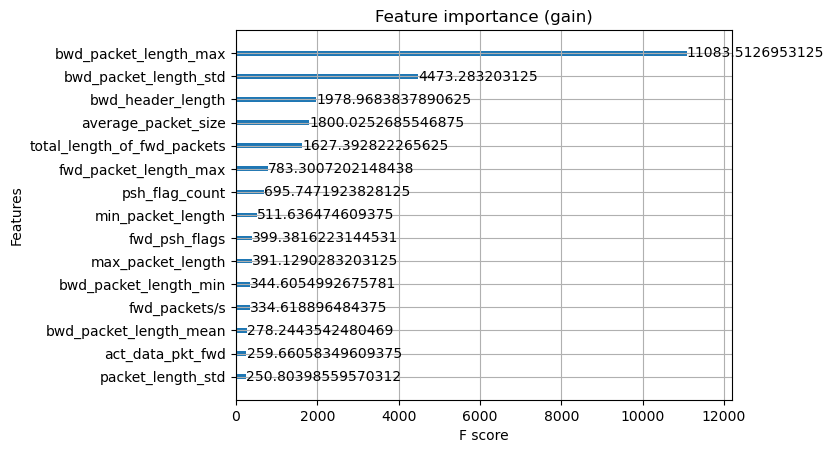

In [70]:
plot_importance(xgb_model_adasyn, max_num_features=15, importance_type='gain')
plt.title('Feature importance (gain)')
plt.show()

#plot_importance(xgb_model_adasyn, max_num_features=15, importance_type='weight')
#plt.title('Feature importance (weight)')
#plt.show()

#plot_importance(xgb_model_adasyn, max_num_features=15, importance_type='cover')
#plt.title('Feature importance (cover)')
#plt.show()

Признак с самым высоким вкладом в точность модели - `bwd_packet_lenght_max`.

Сохраним модель для дальнейшего ее использования во Flask и Docker.

In [66]:
xgb_model_adasyn.save_model('best_xgb_model.bin')

## Вывод:

Была дана задача разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный.

Согласно файлу, доля нормального трафика составляла ~45%, а также 488 пропусков, 65740 дубликатов и бесконечные значения (np.inf), которые составляли значительную долю в своих столбцах. Было принято решение удалить пропуски и дубликаты, а бесконечные значения заменить максимальными и минимальными значениями.
___

Затем взялись за обучение бейзлайновской модели. Выбор пал на три метода: `LogisticRegression`, `XGBClassifier`, `LGBMClassifier`. Лучше всего себя проявила модель `XGBClassifier`:
- Precision: 0.9973
- Recall: 0.9974
- F1 Score: 0.9973
- Accuracy: 0.9974
- Время обучения: 4min 36s

С целью улучшить метрики воспользовались методами семплирования `SMOTE` и `ADASYN`. Второй способ помог в этом, совсем немного повысив результаты `XGBClassifier`:
- Precision: 0.9973 -> **0.9973**
- Recall: 0.9974 -> **0.9974** 
- F1 Score: 0.9973 -> **0.9974** (!)
- Accuracy: 0.9974 -> **0.9974**
- Время обучения: 4min 36s -> **7min 40s**
___

Для определения важности фич воспользовались встроенной в библиотеку `XGBoost` функцией plot_importance, которая визуализирует вклад признаков в точность модели. Признак с самым высоким вкладом в точность модели - `bwd_packet_lenght_max`.
___

Для последующей работы с docker и flask модель была сохранена - `best_xgb_model.bin`